# <center>Traitez les images pour le système embarqué d'une voiture autonome</center>
# <center>Partie I - Analyse exploratoire des images</center>

## Préambule 
### 1 - Contexte

### 2 - Chargement des librairies

In [1]:
# Version Python
!python --version

Python 3.12.3


In [2]:
# Librairies pour la manipulation de données
import numpy as np
import random
import pandas as pd
import polars as pl
import os

# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Librairies pour la visualisation des données
import matplotlib.pyplot as plt
import cv2

# Version bibliothèque partiellement importée
import importlib.metadata

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))
print("matplotlib - ", importlib.metadata.version('matplotlib'))

json - 2.0.9
numpy - 2.2.3
pandas - 2.2.3
polars - 1.22.0
cv2 - 4.11.0
matplotlib -  3.10.0


### 3 - Lecture des fichiers

In [3]:
# Liste des dossiers à notre disposition
chemin_original = "../P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"
chemin_annote = "../P8_Cityscapes_gtFine_trainvaltest/gtFine/train"
liste_dossiers = os.listdir(chemin_annote)
print("Liste des villes présentes dans notre dossier :", liste_dossiers)

Liste des villes présentes dans notre dossier : ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


## I - Analyse Exploratoire des Données

### 1 - Exploration générale

In [4]:
# Nombre de villes à explorer
print("Nous avons à notre disposition des images de", len(liste_dossiers), "villes différentes.")

Nous avons à notre disposition des images de 18 villes différentes.


In [5]:
# Fonction pour compter le nombre d'images par ville
def nb_images(ville, suffixe):
    return len([f for f in os.listdir(ville) if f.endswith(suffixe)])
    
# Liste vide pour stocker le nombre d'images
nb_images_list = []

# Suffixe des fichiers à compter
suffixe = 'leftImg8bit.png'

# Boucle pour stocker le nombre d'images par ville
for i in liste_dossiers:
    images = nb_images(f"{chemin_original}/{i}", suffixe)
    nb_images_list.append(images)           

# Création d'un DataFrame Polars avec des types de données spécifiés
images_ville = pd.DataFrame({
    "ville": liste_dossiers,
    "images": nb_images_list
})

# Ajout de barres colorées pour la colonne 'images'
images_ville = images_ville.style.bar(subset=['images'], color='lightblue', align='mid')

In [6]:
display(images_ville)

Nous avons un bon nombre d'images donc pour notre analyse exploratoire nous allons choisir un échantillon de 10 images par dossier.

### 2 - Extraction des échantillons

In [7]:
# Dictionnaire pour stocker les échantillons
echantillons_annotes = {}

# Fixation de l'aléatoire
random.seed(42)

# Boucle pour échantillonner les images annotées
for i in liste_dossiers:
    dossier_path = f"{chemin_annote}/{i}"
    images_annotees = [f for f in os.listdir(dossier_path) if f.endswith('gtFine_color.png')]

    # Échantillonner 10 images ou moins si le nombre d'images est inférieur à 10
    if len(images_annotees) >= 10:
        echantillons_annotes[i] = random.sample(images_annotees, 80)
    else:
        echantillons_annotes[i] = images_annotees

### 3 - Visualisation de quelques images par ville

In [8]:
# Nouvelles dimensions des images
largeur_cible = 512
hauteur_cible = 256

# Traitement des images annotées et des fichiers JSON associés
for ville, images in echantillons_annotes.items():
    chemin_sortie_annote = f"../Echantillons_redim/Image_annote/{ville}"
    chemin_sortie_label = f"../Echantillons_redim/Label/{ville}"
    chemin_sortie_original = f"../Echantillons_redim/Original/{ville}"
    os.makedirs(chemin_sortie_annote, exist_ok=True)
    os.makedirs(chemin_sortie_label, exist_ok=True)
    os.makedirs(chemin_sortie_original, exist_ok=True)

    for image in images:
        # Traitement de l'image annotée
        source_annote = f"{chemin_annote}/{ville}/{image}"
        destination_annote = f"{chemin_sortie_annote}/{image}"
        img = cv2.imread(source_annote)
        if img is not None:
            img_redimensionnee = cv2.resize(img, (largeur_cible, hauteur_cible))
            cv2.imwrite(destination_annote, img_redimensionnee)

        # Traitement du fichier des labels associés
        image_label = image.replace('gtFine_color.png', 'gtFine_labelIds.png') 
        source_label = f"{chemin_annote}/{ville}/{image_label}"
        destination_label = f"{chemin_sortie_label}/{image_label}"
        img = cv2.imread(source_label)
        if img is not None:
            img_redimensionnee = cv2.resize(img, (largeur_cible, hauteur_cible))
            cv2.imwrite(destination_label, img_redimensionnee)

        # Traitement des images originales
        image_original = image.replace('gtFine_color.png', 'leftImg8bit.png') 
        source_original = f"{chemin_original}/{ville}/{image_original}"
        destination_original = f"{chemin_sortie_original}/{image_original}"
        img = cv2.imread(source_original)
        if img is not None:
            img_redimensionnee = cv2.resize(img, (largeur_cible, hauteur_cible))
            cv2.imwrite(destination_original, img_redimensionnee)
        
        """
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                annotations = json.load(f)
            # Extraire les labels de chaque objet
            for objet in annotations['objects']:
                label = objet.get('label')
                if label:
                    tous_labels.add(label)

            img_height_original = annotations['imgHeight']
            img_width_original = annotations['imgWidth']

            # Créer un masque pour chaque catégorie principale
            for objet in annotations['objects']:
                label = objet.get('label')
                if label:
                    masque = np.zeros((hauteur_cible, largeur_cible), dtype=np.uint8)
                    polygon = np.array(objet['polygon'], dtype=np.int32)

                    # Mettre à l'échelle les coordonnées du polygone
                    polygon[:, 0] = (polygon[:, 0] * largeur_cible / img_width_original).astype(np.int32)
                    polygon[:, 1] = (polygon[:, 1] * hauteur_cible / img_height_original).astype(np.int32)

                    # Résoudre le problème de format
                    polygon = polygon.reshape((-1, 1, 2))
                    cv2.fillPoly(masque, [polygon], 1)

                    # Enregistrer le masque
                    masque_destination = f"{chemin_sortie_masques}/{image.replace('gtFine_color.png', f'{label}_masque.png')}"
                    cv2.imwrite(masque_destination, masque)"""

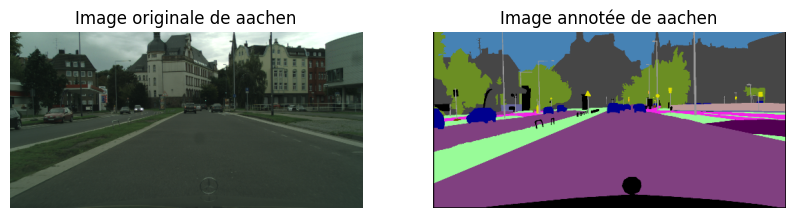

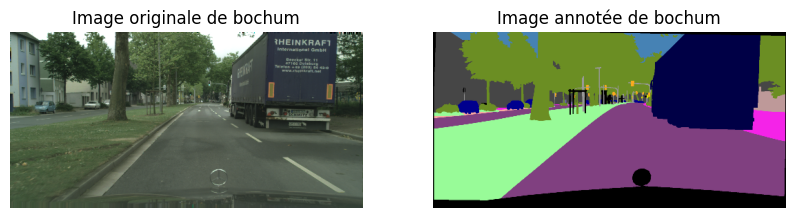

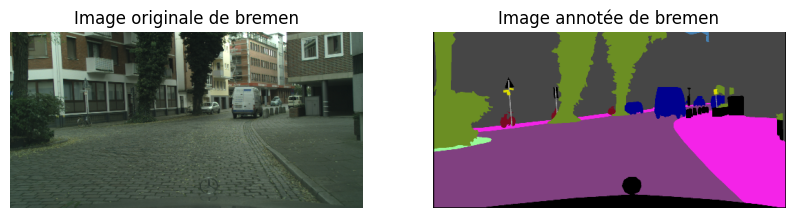

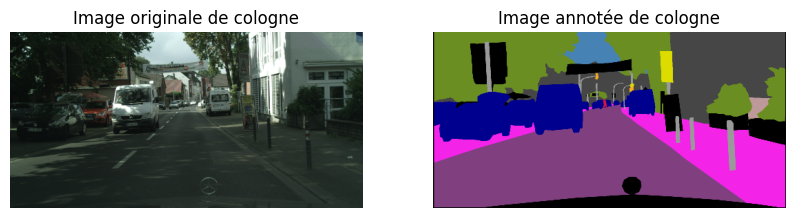

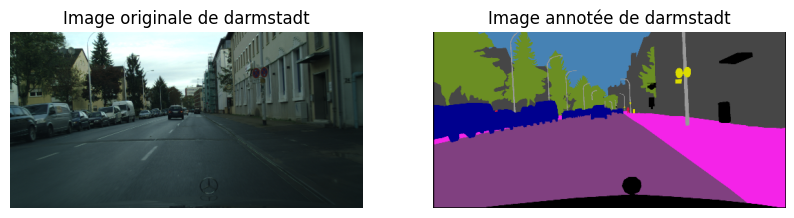

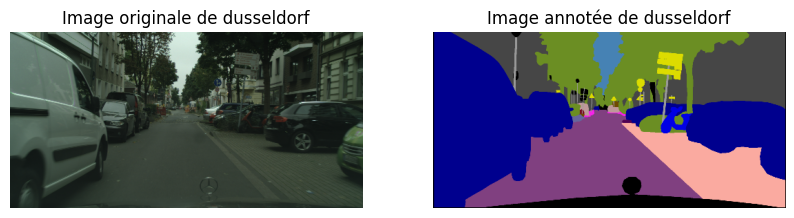

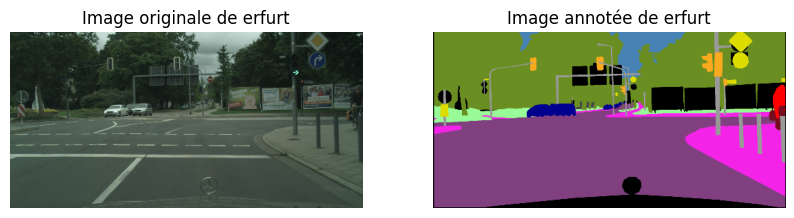

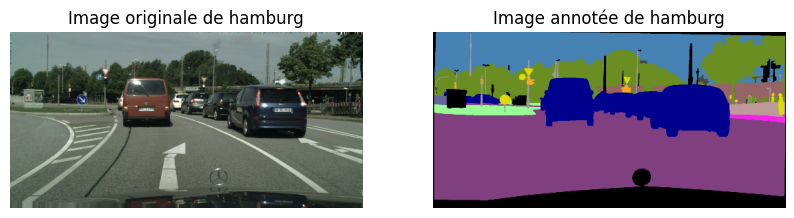

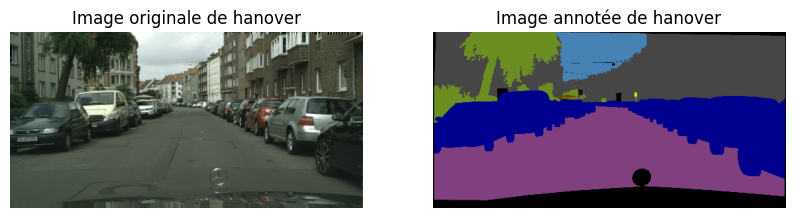

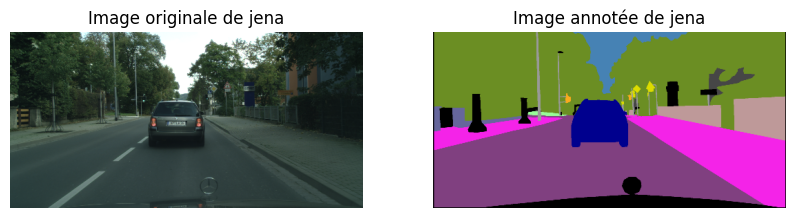

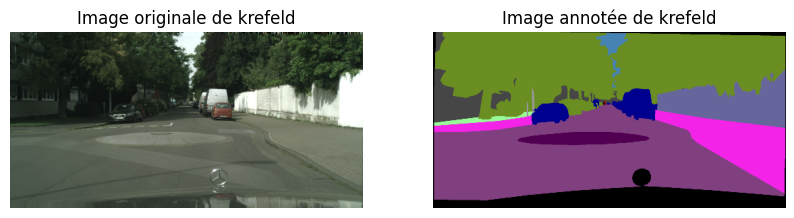

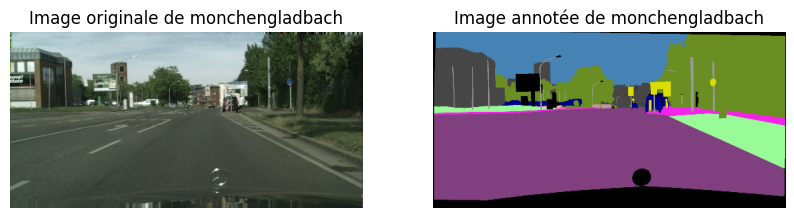

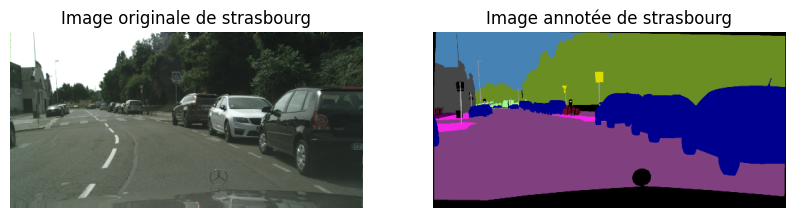

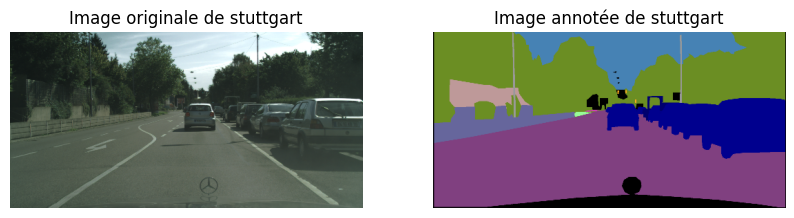

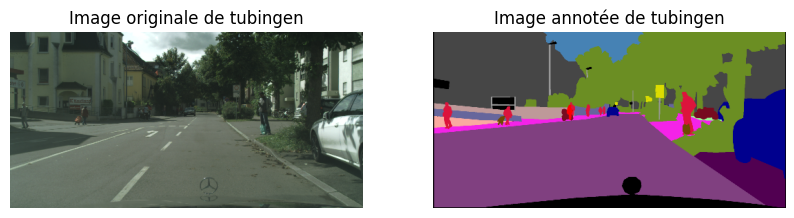

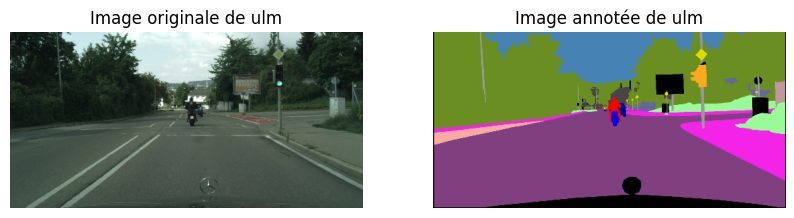

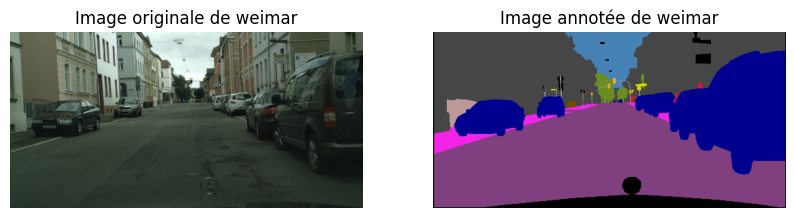

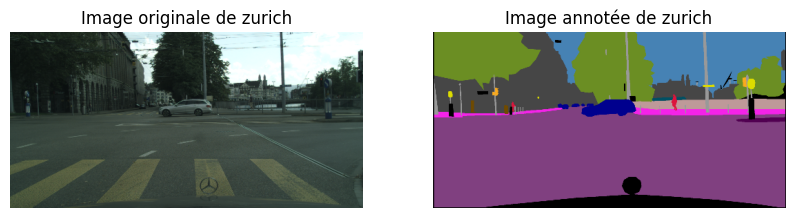

In [9]:
# Affichage des images et masques pour vérification
chemin_redim_annote = "../Echantillons_redim/Image_annote"
chemin_redim_original = "../Echantillons_redim/Original"
dossier_image_annote = os.listdir(chemin_redim_annote)

for dossier in dossier_image_annote:
    images = os.listdir(f"{chemin_redim_annote}/{dossier}/")

    for image_nom in images[:1]: 
        image_annote_path = f"{chemin_redim_annote}/{dossier}/{image_nom}"
        image_annote = cv2.imread(image_annote_path)
        if image_annote is not None:
            image_annote_rgb = cv2.cvtColor(image_annote, cv2.COLOR_BGR2RGB)

        # Trouver l'image originale correspondante
        image_nom_original = image_nom.replace('gtFine_color.png', 'leftImg8bit.png')
        image_original_path = f"{chemin_redim_original}/{dossier}/{image_nom_original}"
        image_original = cv2.imread(image_original_path)
        if image_original is not None:
            image_original_rgb = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)

        if image_annote is not None and image_original is not None:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image_original_rgb)
            plt.axis('off')
            plt.title(f'Image originale de {dossier}')

            plt.subplot(1, 2, 2)
            plt.imshow(image_annote_rgb)
            plt.axis('off')
            plt.title(f'Image annotée de {dossier}')

            plt.show()

Nous avons un exemple pour chacune des villes, cependant, les images annotées contiennent une trentaine de sous-catégories, il nous faut donc les regrouper en 8 catégories principales.

## II - Redéfinition des masques de catégories

### 1 - Dictionnaires de correspondance 

In [10]:
# Affichage des images et masques pour vérification
chemin_redim_label = "../Echantillons_redim/Label"
dossier_image_label = os.listdir(chemin_redim_label)

unique_values = set()

for dossier in dossier_image_label:
    images = os.listdir(f"{chemin_redim_label}/{dossier}/")

    for image_nom in images:
        image_label_path = f"{chemin_redim_label}/{dossier}/{image_nom}"
        image_label = cv2.imread(image_label_path, cv2.IMREAD_GRAYSCALE)  # Lire en niveaux de gris
        if image_label is not None:
            # Ajouter les valeurs uniques de cette image au set global
            unique_values.update(np.unique(image_label).astype(int))

# Afficher toutes les valeurs uniques trouvées
print("Valeurs uniques dans les images de label :", sorted(unique_values))

Valeurs uniques dans les images de label : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33)]


In [11]:
# Création du dictionnaire de correspondance 
groupes = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33]
          }

In [12]:
# Palette de couleurs pour chaque catégorie
colors = {
    'void': [0, 0, 0],          # Noir
    'flat': [128, 0, 0],        # Marron
    'construction': [0, 128, 0],# Vert
    'object': [128, 128, 0],    # Olive
    'nature': [0, 0, 128],      # Bleu marine
    'sky': [128, 0, 128],       # Violet
    'human': [0, 128, 128],     # Turquoise
    'vehicle': [128, 128, 128]  # Gris
}

### 2 - Création des masques en 8 couleurs

In [13]:
# Chemin pour enregistrer les nouveaux masques
chemin_sortie_categorie = "../Echantillons_redim/Image_annote_categorie"
os.makedirs(chemin_sortie_categorie, exist_ok=True)

for dossier in dossier_image_label:
    images = os.listdir(f"{chemin_redim_label}/{dossier}/")

    # Créer le dossier pour les nouveaux masques si nécessaire
    dossier_categorie = os.path.join(chemin_sortie_categorie, dossier)
    os.makedirs(dossier_categorie, exist_ok=True)

    for image_nom in images:
        image_label_path = f"{chemin_redim_label}/{dossier}/{image_nom}"
        image_label = cv2.imread(image_label_path, cv2.IMREAD_GRAYSCALE)  # Lire en niveaux de gris
        if image_label is not None:
            # Créer un nouveau masque en couleur
            new_mask = np.zeros((image_label.shape[0], image_label.shape[1], 3), dtype=np.uint8)

            for category, subcategories in groupes.items():
                for subcategory in subcategories:
                    new_mask[image_label == subcategory] = colors[category]

            # Enregistrer le nouveau masque
            new_image_nom = image_nom.replace("gtFine_labelIds.png", "8_categories.png")
            nouveau_masque_path = os.path.join(dossier_categorie, new_image_nom)
            cv2.imwrite(nouveau_masque_path, new_mask)

In [14]:
# Vérification de la conversion
chemin_redim_categorie = "../Echantillons_redim/Image_annote_categorie"
dossier_image_categorie = os.listdir(chemin_redim_categorie)

unique_values = set()

for dossier in dossier_image_categorie:
    images = os.listdir(f"{chemin_redim_categorie}/{dossier}/")

    for image_nom in images:
        image_categorie_path = f"{chemin_redim_categorie}/{dossier}/{image_nom}"
        image_categorie = cv2.imread(image_categorie_path, cv2.IMREAD_GRAYSCALE)  # Lire en niveaux de gris
        if image_categorie is not None:
            # Ajouter les valeurs uniques de cette image au set global
            unique_values.update(np.unique(image_categorie).astype(int))

# Afficher toutes les valeurs uniques trouvées
print("Valeurs uniques dans les images de catégorie :", sorted(unique_values))
print("Nombre de  valeurs différentes dans les images de catégorie :", len(unique_values))

Valeurs uniques dans les images de catégorie : [np.int64(0), np.int64(14), np.int64(38), np.int64(52), np.int64(75), np.int64(89), np.int64(113), np.int64(128)]
Nombre de  valeurs différentes dans les images de catégorie : 8


Le dossier a bien été créé et la conversion semble être cohérente car nous retrouvons bien 8 couleurs dans nos images.

### 3 - Visualisation de quelques images par ville

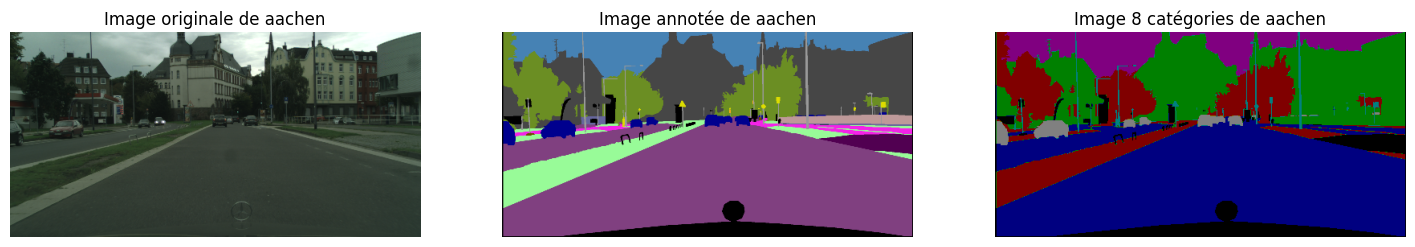

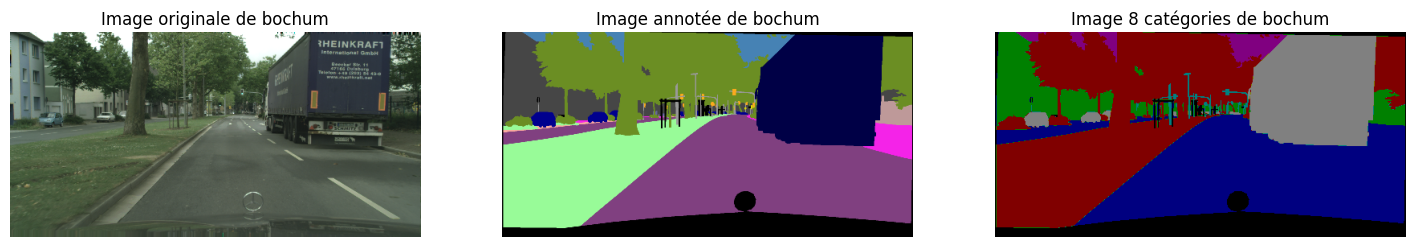

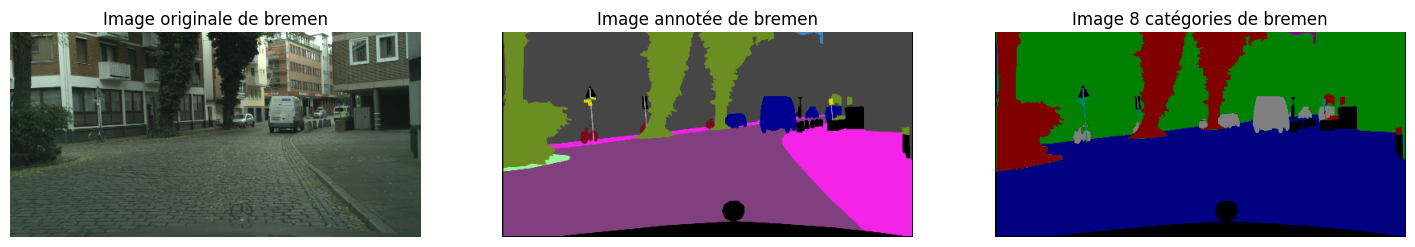

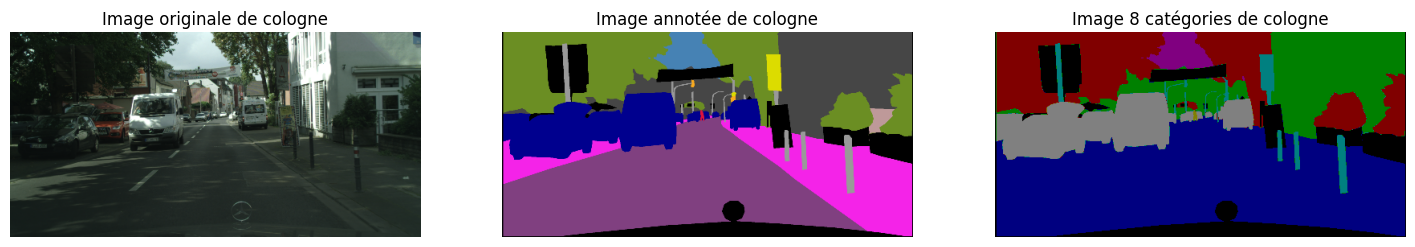

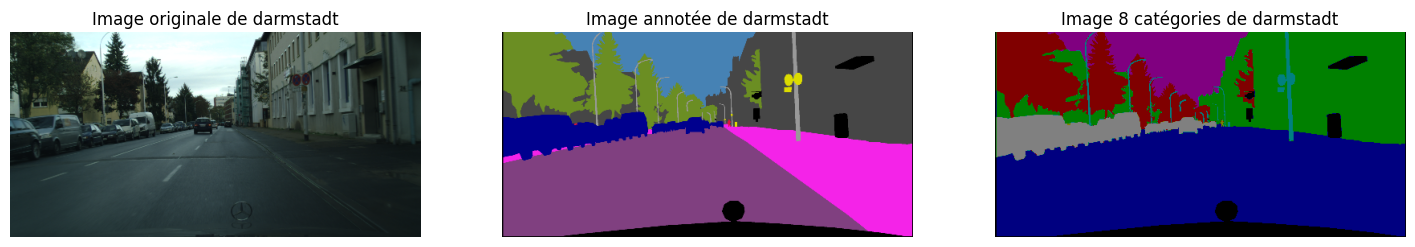

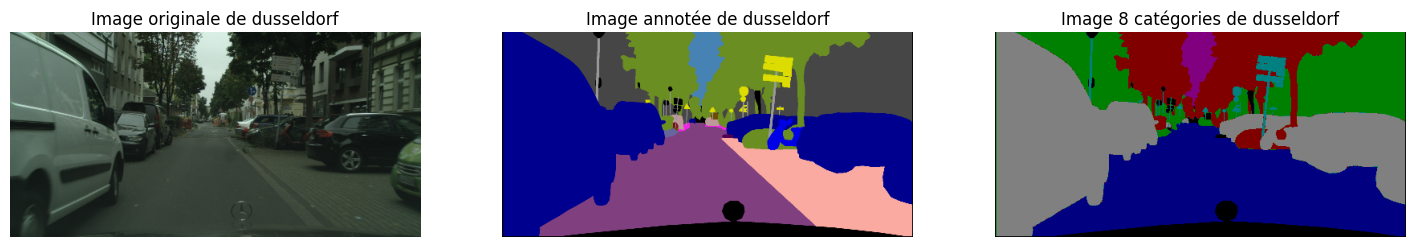

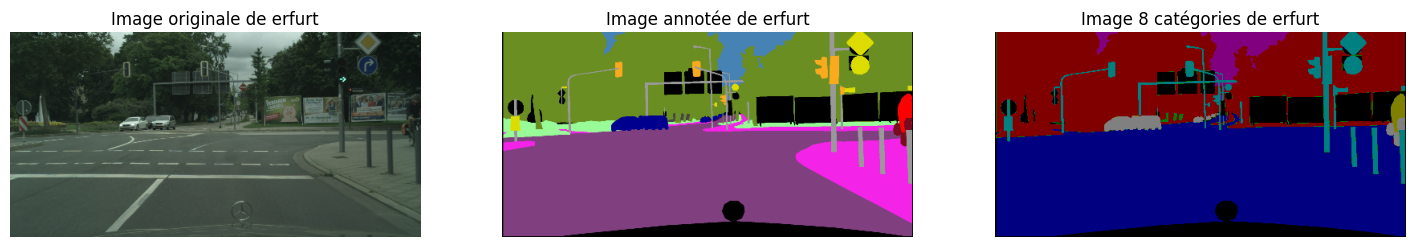

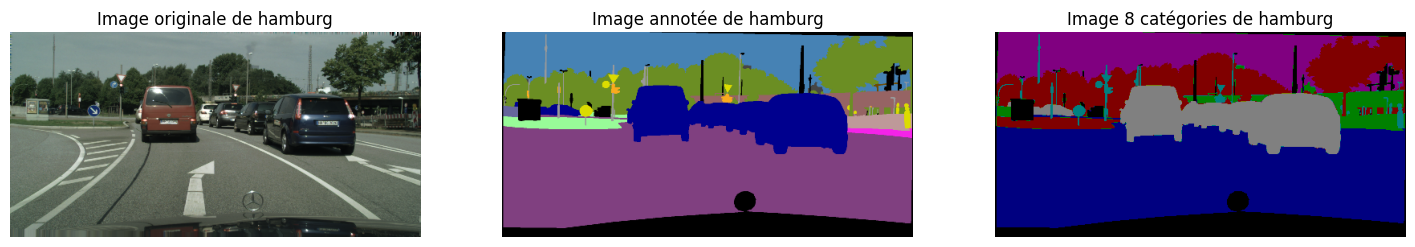

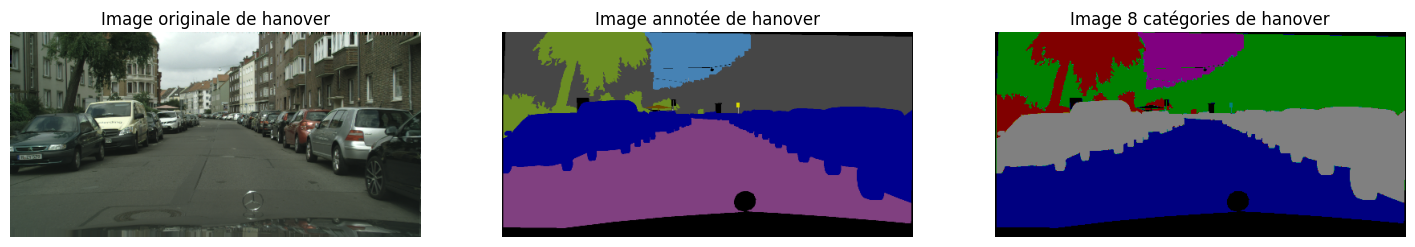

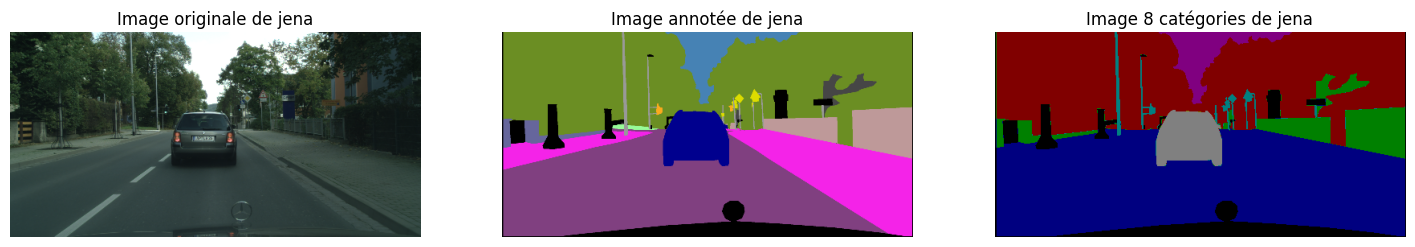

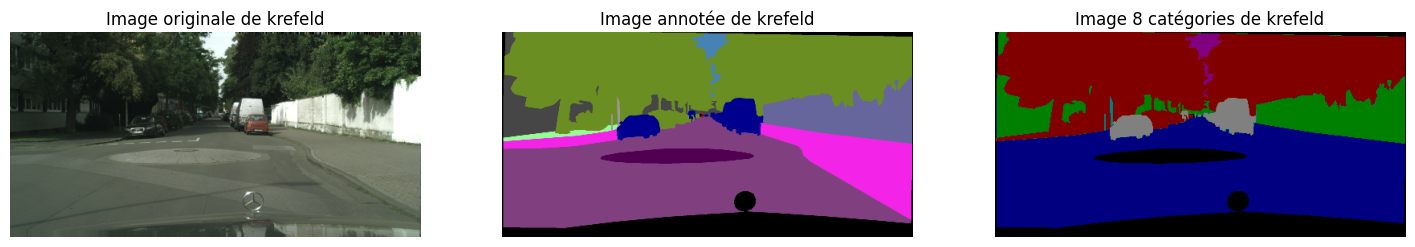

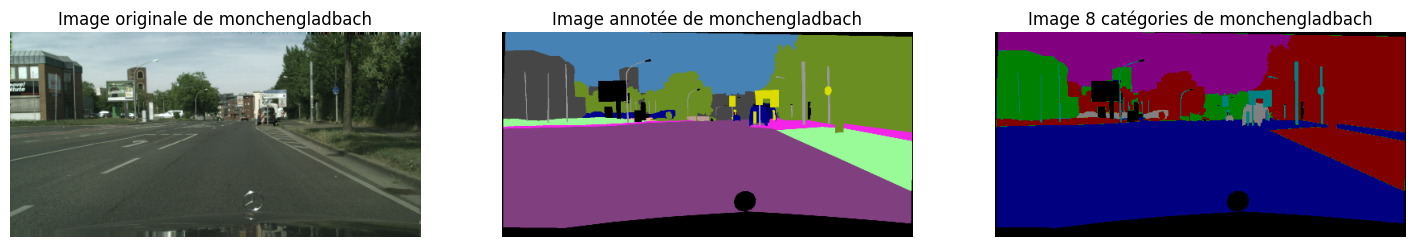

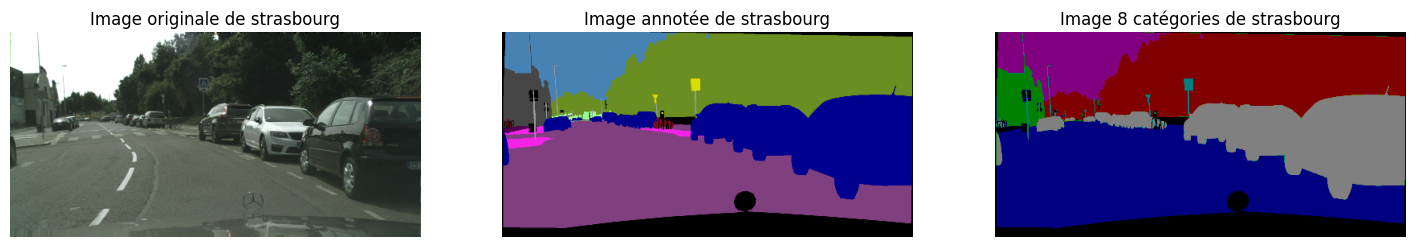

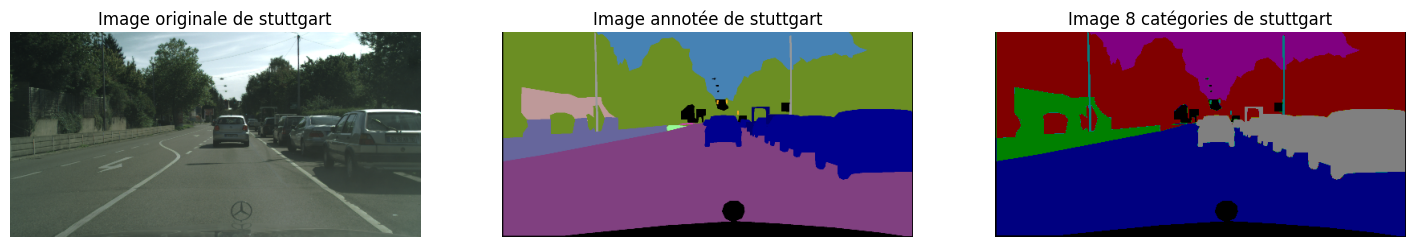

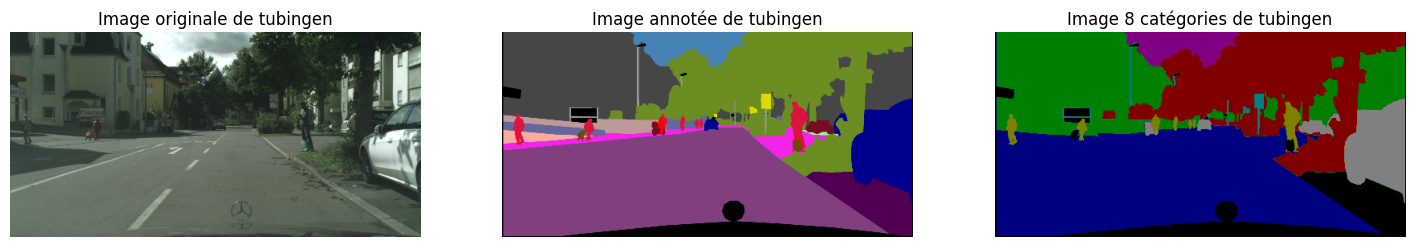

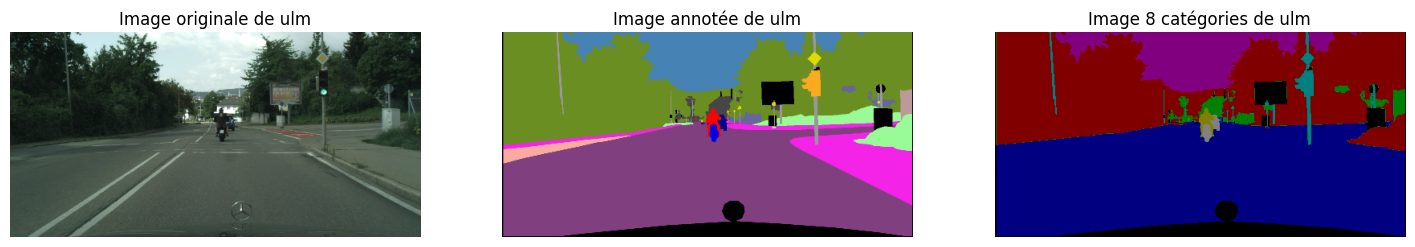

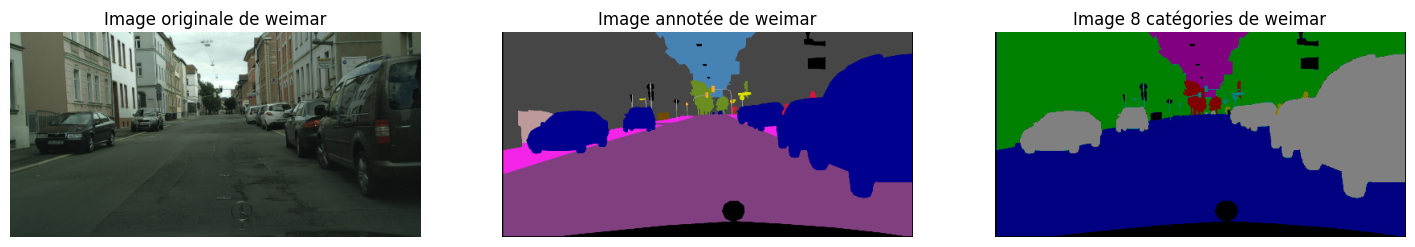

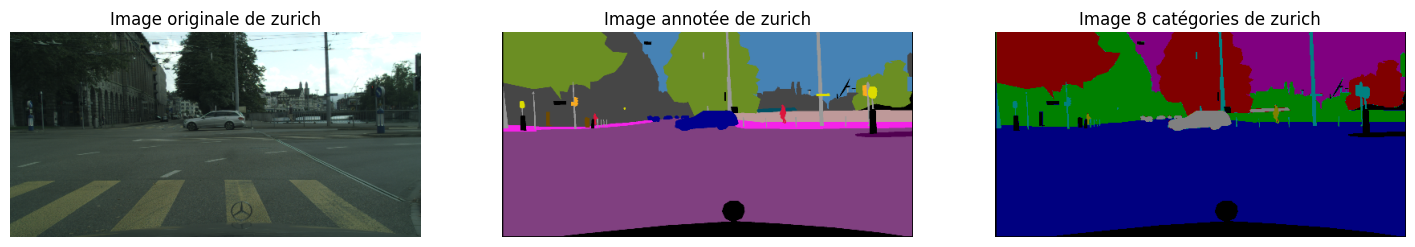

In [15]:
# Affichage des images et masques pour vérification
chemin_redim_annote = "../Echantillons_redim/Image_annote"
chemin_redim_original = "../Echantillons_redim/Original"
chemin_redim_categorie = "../Echantillons_redim/Image_annote_categorie"
dossier_image_annote = os.listdir(chemin_redim_annote)

for dossier in dossier_image_annote:
    images = os.listdir(f"{chemin_redim_annote}/{dossier}/")

    for image_nom in images[:1]: 
        image_annote_path = f"{chemin_redim_annote}/{dossier}/{image_nom}"
        image_annote = cv2.imread(image_annote_path)
        if image_annote is not None:
            image_annote_rgb = cv2.cvtColor(image_annote, cv2.COLOR_BGR2RGB)

        # Trouver l'image originale correspondante
        image_nom_original = image_nom.replace('gtFine_color.png', 'leftImg8bit.png')
        image_original_path = f"{chemin_redim_original}/{dossier}/{image_nom_original}"
        image_original = cv2.imread(image_original_path)
        if image_original is not None:
            image_original_rgb = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)

        # Trouver l'image avec 8 catégories correspondante
        image_nom_categorie = image_nom.replace("gtFine_color.png", "8_categories.png")
        image_categorie_path = f"{chemin_redim_categorie}/{dossier}/{image_nom_categorie}"
        image_categorie = cv2.imread(image_categorie_path)
        if image_categorie is not None:
            image_categorie_rgb = cv2.cvtColor(image_categorie, cv2.COLOR_BGR2RGB)

        if image_annote is not None and image_original is not None and image_categorie is not None:
            plt.figure(figsize=(18, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image_original_rgb)
            plt.axis('off')
            plt.title(f'Image originale de {dossier}')

            plt.subplot(1, 3, 2)
            plt.imshow(image_annote_rgb)
            plt.axis('off')
            plt.title(f'Image annotée de {dossier}')

            plt.subplot(1, 3, 3)
            plt.imshow(image_categorie_rgb)
            plt.axis('off')
            plt.title(f'Image 8 catégories de {dossier}')

            plt.show()